https://github.com/scign/GuidedLDA/blob/master/Guided%20LDA%20using%20gensim.ipynb

In [1]:
import gensim
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sdeshpande/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Error loading pos_tag: Package 'pos_tag' not found in
[nltk_data]     index
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sdeshpande/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
txt = [
    'I like to eat broccoli and bananas.',
    'I munched a banana and spinach smoothie for breakfast.',
    'Chinchillas and kittens are cute.',
    'My sister adopted a kitten yesterday.',
    'Look at this cute hamster munching on a piece of broccoli.'
]
len(txt)

5

In [6]:
# simplify Penn tags to n (NOUN), v (VERB), a (ADJECTIVE) or r (ADVERB)
def simplify(penn_tag):
    pre = penn_tag[0]
    if (pre == 'J'):
        return 'a'
    elif (pre == 'R'):
        return 'r'
    elif (pre == 'V'):
        return 'v'
    else:
        return 'n'

In [7]:
def preprocess(text):
    stop_words = stopwords.words('english')
    toks = gensim.utils.simple_preprocess(str(text), deacc=True)
    wn = WordNetLemmatizer()
    return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks) if tok not in stop_words]

In [8]:
corp = [preprocess(line) for line in txt]
corp

[['like', 'eat', 'broccoli', 'banana'],
 ['munch', 'banana', 'spinach', 'smoothie', 'breakfast'],
 ['chinchilla', 'kitten', 'cute'],
 ['sister', 'adopt', 'kitten', 'yesterday'],
 ['look', 'cute', 'hamster', 'munch', 'piece', 'broccoli']]

In [9]:
dictionary = gensim.corpora.Dictionary(corp)
len(dictionary)

17

In [10]:
bow = [dictionary.doc2bow(line) for line in corp]
bow

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1)],
 [(1, 1), (5, 1), (9, 1), (14, 1), (15, 1), (16, 1)]]

In [11]:
def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) for t in range(ntopics) for w,p in model.get_topic_terms(t, topn=1)]
    terms = [modeldict[w] for w in modeldict.keys()]
    fig,ax=plt.subplots()
    ax.imshow(model.get_topics())  # plot the numpy matrix
    ax.set_xticks(modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

In [12]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    # visuzlize the model term topics
    viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=3)]))
    if print_dist:
        # display the topic probabilities for each document
        for line,bag in zip(txt,bow):
            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print('{} {}'.format(line, doc_topics))
    return model

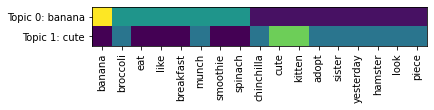

Perplexity: -3.23
Topic 0: ['banana', 'like', 'smoothie']
Topic 1: ['kitten', 'cute', 'adopt']
I like to eat broccoli and bananas. ['(0, 99.1%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 99.3%)']
Chinchillas and kittens are cute. ['(1, 99.2%)']
My sister adopted a kitten yesterday. ['(1, 99.4%)']
Look at this cute hamster munching on a piece of broccoli. ['(1, 99.6%)']


In [13]:
# Before we try a custom prior distribution, let's see how the model does with the default setting, i.e. 'auto'.
test_eta('auto',dictionary,ntopics=2)

To define a prior distribution, we need to create a numpy matrix with the same number of rows and columns as topics and terms, respectively. We then populate that matrix with our prior distribution. To do this we pre-populate all the matrix elements with 1, then with a really high number for the elements that correspond to our 'guided' term-topic distribution

In [14]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

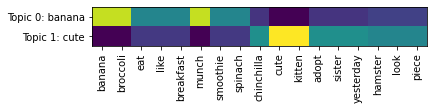

Perplexity: -1.30
Topic 0: ['banana', 'broccoli', 'munch']
Topic 1: ['kitten', 'cute', 'sister']
I like to eat broccoli and bananas. ['(0, 96.3%)', '(1, 3.7%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 97.0%)', '(1, 3.0%)']
Chinchillas and kittens are cute. ['(0, 4.8%)', '(1, 95.2%)']
My sister adopted a kitten yesterday. ['(0, 3.7%)', '(1, 96.3%)']
Look at this cute hamster munching on a piece of broccoli. ['(0, 40.4%)', '(1, 59.6%)']


In [15]:
# Let's start with a list that uses the same topic words.
apriori_original = {
    'banana':0, 'broccoli':0, 'munch':0,
    'cute':1, 'kitten':1  # we'll leave out broccoli from this one!
}
eta = create_eta(apriori_original, dictionary, 2)
test_eta(eta, dictionary, 2)

# When we guide the distribution to allocate a few words towards the 'foody' topic and others towards the 'animaly' topic, we actually get a more pronounced distribution in the same topic allocation direction, and we even get more probability assiged to both topics for the last sentence.

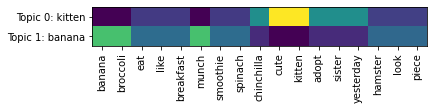

Perplexity: -1.46
Topic 0: ['kitten', 'cute', 'chinchilla']
Topic 1: ['banana', 'broccoli', 'munch']
I like to eat broccoli and bananas. ['(0, 8.3%)', '(1, 91.7%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 6.9%)', '(1, 93.1%)']
Chinchillas and kittens are cute. ['(0, 86.8%)', '(1, 13.2%)']
My sister adopted a kitten yesterday. ['(0, 89.3%)', '(1, 10.7%)']
Look at this cute hamster munching on a piece of broccoli. ['(0, 22.9%)', '(1, 77.1%)']


In [17]:
apriori_opposite = {
    'cute':0, 'kitten':0,
    'banana':1, 'broccoli':1, 'munch':1
}
eta = create_eta(apriori_opposite, dictionary, 2)
test_eta(eta, dictionary, 2)

# Success! We've pushed the model in the opposite direction. Terms that were previously assigned to topic 0 are now topic 1, and vice-versa. However it looks like the model struggled with this a bit! The distribution is not as clear-cut. What if we push a little harder?

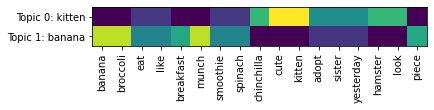

Perplexity: -1.17
Topic 0: ['kitten', 'cute', 'chinchilla']
Topic 1: ['banana', 'munch', 'broccoli']
I like to eat broccoli and bananas. ['(0, 4.1%)', '(1, 95.9%)']
I munched a banana and spinach smoothie for breakfast. ['(0, 3.3%)', '(1, 96.7%)']
Chinchillas and kittens are cute. ['(0, 94.6%)', '(1, 5.4%)']
My sister adopted a kitten yesterday. ['(0, 95.8%)', '(1, 4.2%)']
Look at this cute hamster munching on a piece of broccoli. ['(0, 50.0%)', '(1, 50.0%)']


In [18]:
apriori_harder = {
    'cute':0, 'kitten':0, 'hamster':0, 'chinchilla':0, 'look':0,
    'banana':1, 'broccoli':1, 'piece':1, 'breakfast':1, 'munch':1
}
eta = create_eta(apriori_harder, dictionary, 2)
test_eta(eta, dictionary, 2)


In [19]:
# Try guided LDA on Biomedical text
import pandas as pd 
medical_df = pd.read_csv("/Users/sdeshpande/Desktop/bioinformatices/full_articlesLDA.csv")

In [20]:
medical_df.head()

,Unnamed: 0,paper_id,title,abstract,body_text,doi,title_abstract_body
0,0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,http://doi.org/10.1016/j.vetmic.2006.11.026,Absence of surface expression of feline infect...
1,1,000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a,Correlation between antimicrobial consumption ...,Objectives: This study was conducted to invest...,The incidence of health-care-associated infect...,http://doi.org/10.1016/j.jmii.2013.10.008,Correlation between antimicrobial consumption ...
2,2,000e754142ba65ef77c6fdffcbcbe824e141ea7b,Laboratory-based surveillance of hospital-acqu...,"Of 7,772 laboratory-confirmed cases of respira...",The human respiratory viruses include adenovir...,http://doi.org/10.1016/j.ajic.2017.01.009,Laboratory-based surveillance of hospital-acqu...
3,3,000eec3f1e93c3792454ac59415c928ce3a6b4ad,Pneumonie virale sévère de l'immunocompétent V...,Reçu et accepté le 7 février 2004 Les infectio...,Les pathologies infectieuses respiratoires son...,http://doi.org/10.1016/j.reaurg.2004.02.009,Pneumonie virale sévère de l'immunocompétent V...
4,4,001259ae6d9bfa9376894f61aa6b6c5f18be2177,Microheterogeneity of S-glycoprotein of mouse ...,"IEF, isoelectric focusing; NC, nitrocellulose;...",(Accepted 10 January 1992) is a neurotropic co...,http://doi.org/10.1016/0166-0934(92)90173-B,Microheterogeneity of S-glycoprotein of mouse ...


In [21]:
medical_df = medical_df[["doi", "title", "abstract"]]
medical_df.head(10)

,doi,title,abstract
0,http://doi.org/10.1016/j.vetmic.2006.11.026,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...
1,http://doi.org/10.1016/j.jmii.2013.10.008,Correlation between antimicrobial consumption ...,Objectives: This study was conducted to invest...
2,http://doi.org/10.1016/j.ajic.2017.01.009,Laboratory-based surveillance of hospital-acqu...,"Of 7,772 laboratory-confirmed cases of respira..."
3,http://doi.org/10.1016/j.reaurg.2004.02.009,Pneumonie virale sévère de l'immunocompétent V...,Reçu et accepté le 7 février 2004 Les infectio...
4,http://doi.org/10.1016/0166-0934(92)90173-B,Microheterogeneity of S-glycoprotein of mouse ...,"IEF, isoelectric focusing; NC, nitrocellulose;..."
5,http://doi.org/10.3389/fimmu.2015.00527,immunity to pathogens taught by specialized hu...,Dendritic cells (DCs) are specialized antigen-...
6,http://doi.org/10.1101/2020.01.10.901801,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 24...
7,http://doi.org/10.1016/0166-0934(94)00119-2,Enhancement of feline infectious peritonitis v...,The effects of centrifugation on the ability o...
8,http://doi.org/10.1016/j.econmod.2016.02.017,Intervention time series analysis of crime rat...,We review the basic concepts of intervention a...
9,http://doi.org/10.1016/j.cimid.2018.09.011,Changes in salivary analytes in canine parvovi...,The present study evaluated the changes in sal...


In [22]:
medical_df = medical_df[0:10000]

In [23]:
title_text = medical_df.title.tolist()

In [24]:
corp = [preprocess(line) for line in title_text]

In [25]:
dictionary = gensim.corpora.Dictionary(corp)
len(dictionary)

12207

In [26]:
bow = [dictionary.doc2bow(line) for line in corp]

In [45]:
def test_eta_large(eta, dictionary, ntopics, print_topics=True, print_dist=False):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=200, alpha='auto', per_word_topics=True)
    # visuzlize the model term topics
    #viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=5)]))
    if print_dist:
        # display the topic probabilities for each document
        for line,bag in zip(txt,bow):
            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print('{} {}'.format(line, doc_topics))
    return model

In [46]:
test_eta_large('auto',dictionary,ntopics=5)

Perplexity: -8.23
Topic 0: ['infection', 'respiratory', 'coronavirus', 'syndrome', 'study']
Topic 1: ['cell', 'human', 'gene', 'expression', 'receptor']
Topic 2: ['rna', 'genome', 'child', 'structure', 'sequence']
Topic 3: ['disease', 'infectious', 'detection', 'health', 'nan']
Topic 4: ['virus', 'protein', 'viral', 'influenza', 'analysis']


In [47]:
apriori_harder = {
    'expression':0, 'diagnostic':0, 'test':0, 'experiment':0, 'intervention': 0, 'infection':0, 'vaccination':0, 'transmission':0,
    'mouse':1, 'feline':1, 'mammal':1, 'monkey':1, 'canine':1, 'human':1, 'cat':1, 'kitten':1,
    'bacterium':2, 'virus':2, 'microorganism':2, 'cell':2, 'microbial':2, 'pathogen':2, 'parvovirus': 2, 'viral':2, 'genome':2, 'bacterial':2,
    'laboratory':3, 'hospital':3, 'pharmaceutical':3,
    'protein':4, 'albumin':4, 'glycoprotein':4, 'antibody':4, 'rna':4, 'nucleocapsid':4, 'coronavirus':4}

In [48]:
eta = create_eta(apriori_harder, dictionary, 5)
test_eta_large(eta, dictionary, 5)

Perplexity: -4.08
Topic 0: ['infection', 'respiratory', 'coronavirus', 'syndrome', 'study']
Topic 1: ['cell', 'human', 'gene', 'expression', 'receptor']
Topic 2: ['rna', 'genome', 'child', 'structure', 'sequence']
Topic 3: ['disease', 'infectious', 'detection', 'health', 'nan']
Topic 4: ['virus', 'protein', 'viral', 'influenza', 'analysis']
